In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
dataset = pd.read_csv('/content/drive/My Drive/housing.csv')
dataset = dataset.dropna()
dataset.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85ed7dde10>],
      dtype=object)

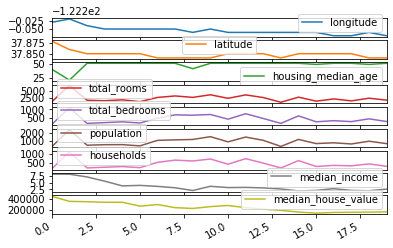

In [3]:
dataset.iloc[0:20].plot(subplots=True, layout=(9,1))

In [4]:
datasetNorm = dataset.drop('ocean_proximity', 1)
datasetNorm = ((datasetNorm-datasetNorm.min())/(datasetNorm.max()-datasetNorm.min()))*50
dataset = datasetNorm
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,10.557769,28.374070,39.215686,1.116537,0.993172,0.447042,1.027791,26.983421,45.113319
1,10.607570,28.267800,19.607843,9.025128,8.573867,3.360520,9.348791,26.901353,35.412328
2,10.507968,28.214665,50.000000,1.863014,1.466480,0.690883,1.447130,23.301403,34.752537
3,10.458167,28.214665,50.000000,1.617580,1.815642,0.777768,1.792468,17.734928,33.639140
4,10.458167,28.214665,50.000000,2.066484,2.164804,0.787578,2.121362,11.538806,33.731923


In [0]:
Y = dataset['median_house_value']
X = dataset.loc[:,'longitude':'median_income']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2003)

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Dropout
from torch.nn import BatchNorm1d

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs

    self.input_layer = Conv1d(inputs, 256, 1)
    self.max_pooling_layer = MaxPool1d(1)
    self.batch_norm = BatchNorm1d(256)
    self.conv_layer = Conv1d(256, 512, 1)
    self.batch_norm1 = BatchNorm1d(512)

    #self.conv_layer2 = Conv1d(512, 1024, 1)
    #self.batch_norm2 = BatchNorm1d(1024)
    
    self.flatten_layer = Flatten()
    #self.linear_layer4 = Linear(1024, 2048)
    #self.linear_layer5 = Linear(2048, 1024)
    #self.linear_layer6 = Linear(1024, 512)
    self.linear_layer = Linear(512, 8192)
    self.linear_layer2 = Linear(8192,4096)
    self.drop = Dropout(0.1)
    self.linear_layer3 = Linear(4096,1024)
    self.linear_layer4 = Linear(1024,128)
    self.output_layer = Linear(128, outputs)

  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    output = self.batch_norm(output)
    output = relu(self.conv_layer(output))
    output = self.batch_norm1(output)

    #output = relu(self.conv_layer2(output))
    #output = self.batch_norm2(output)

    output = self.flatten_layer(output)
    #output = self.linear_layer4(output)
    #output = self.linear_layer5(output)
    #output = self.linear_layer6(output)
    output = self.linear_layer(output)
    output = self.linear_layer2(output)
    output = self.drop(output)
    output = self.linear_layer3(output)
    output = self.linear_layer4(output)
    output = self.output_layer(output)
    return output

In [8]:
from torch.optim import SGD
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 2.6MB/s 


In [17]:
batch_size = 64
model = CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 256, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_layer): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=512, out_features=8192, bias=True)
  (linear_layer2): Linear(in_features=8192, out_features=4096, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (linear_layer3): Linear(in_features=4096, out_features=1024, bias=True)
  (linear_layer4): Linear(in_features=1024, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [0]:
from torch.nn import MSELoss
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()
  mse = MSELoss()

  avg_loss = 0
  avg_score = 0
  avg_mse = 0
  count = 0
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    mse_loss = mse(predictions, output)
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss += loss.item()
    avg_score += score
    avg_mse += mse_loss.item()
    count += 1

  return avg_loss / count, avg_score / count, avg_mse/count

In [18]:
epochs = 50
optimizer = SGD(model.parameters(), lr=0.0001)

inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
losses = []
scores = []
mses = []
for epoch in range(epochs):
  avg_loss, avg_r2_score, avg_mse = model_loss(model, loader, train=True, optimizer=optimizer)
  losses.append(avg_loss)
  scores.append(avg_r2_score)
  mses.append(avg_mse)
  print("Epoch", epoch+1, ':\n\tLoss=', avg_loss, ':\n\tScore=', avg_r2_score, '\n\tMSE=', avg_mse)

Epoch 1 :
	Loss= 19.816283059227093 :
	Score= -2.7929578797079655 
	MSE= 533.6697165998108
Epoch 2 :
	Loss= 19.775831205427913 :
	Score= -2.8068752024024466 
	MSE= 532.0295802916112
Epoch 3 :
	Loss= 19.728655259170875 :
	Score= -2.726817806925447 
	MSE= 530.380494806264
Epoch 4 :
	Loss= 19.685259695010334 :
	Score= -2.7187931573643334 
	MSE= 528.6197225117363
Epoch 5 :
	Loss= 19.634234629404386 :
	Score= -2.7171033872591925 
	MSE= 526.5664327989244
Epoch 6 :
	Loss= 19.580703046824365 :
	Score= -2.717527231762087 
	MSE= 524.5186149015555
Epoch 7 :
	Loss= 19.546811407457017 :
	Score= -2.7024284168946635 
	MSE= 523.3137328827862
Epoch 8 :
	Loss= 19.4948078506196 :
	Score= -2.696332860658847 
	MSE= 521.3418540783528
Epoch 9 :
	Loss= 19.445561310635554 :
	Score= -2.7225036575738226 
	MSE= 519.4962264946223
Epoch 10 :
	Loss= 19.38833974829704 :
	Score= -2.6665272950243915 
	MSE= 517.2645263671875
Epoch 11 :
	Loss= 19.337930439833567 :
	Score= -2.6887594955480454 
	MSE= 515.3783130047033
Epoc

In [19]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score, avg_mse = model_loss(model, loader)
print('Model Loss = ', avg_loss)
print('Model R2Score = ', avg_r2_score)
print('MSE=', avg_mse)
model_save_name = '1121117_1dconv_reg.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

Model Loss =  4.391616286729511
Model R2Score =  0.7137306363598173
MSE= 41.07003733986303


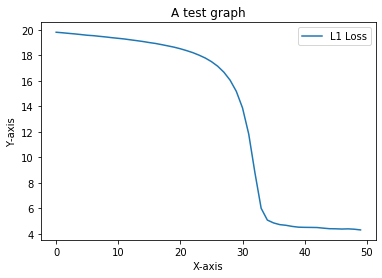

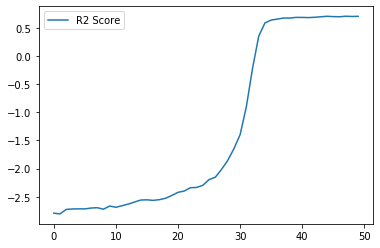

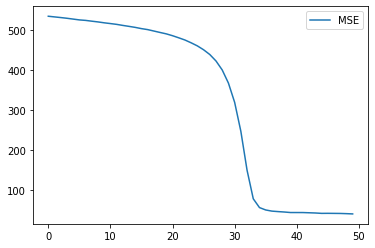

In [20]:
import matplotlib.pyplot as plt

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("A test graph")
plt.plot(losses, label = 'L1 Loss')
plt.legend()
plt.show()
plt.plot(scores, label = 'R2 Score')
plt.legend()
plt.show()
plt.plot(mses, label = 'MSE')
plt.legend()
plt.show()